In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Input, Dropout, concatenate
from keras.layers import Concatenate,Conv2D,BatchNormalization,MaxPooling2D
from keras.optimizers import Adam
from keras import initializers

C:\Users\SERVER\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\SERVER\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\SERVER\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\SERVER\Anaconda3\lib\site-packages\tensorflow\python\framew

In [3]:
class iDQNAgent:
    def __init__(self, state_space , action_space, episodes=500 , memory_size = 50000):
        self.action_space = action_space
        self.memory = []
        self.memory_size = memory_size
        self.gamma = 0.9
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = self.epsilon_min / self.epsilon
        self.epsilon_decay = self.epsilon_decay ** (1. / float(episodes))
        
        n_inputs = state_space.shape[0]
        n_outputs = action_space.n
        
        self.q_model = self.build_model(n_inputs , n_outputs)
        self.q_model.compile(loss='mse' , optimizer=Adam())
        
        self.target_q_model = self.build_model(n_inputs , n_outputs)
        
        self.update_weights()
        self.replay_counter = 0
        
        ####################################################
    def build_model(self, n_inputs , n_outputs):
        inputs = Input(shape = (n_inputs,) , name='state')
        x = Dense(256 , activation='relu')(inputs)
        x = Dense(256 , activation='relu')(x)
        x = Dense(256 , activation='relu')(x)
        x = Dense(n_outputs , activation='linear' , name = 'action')(x)
        model = Model(inputs , x)
        model.summary()
        return model
    
        #####################################################
    def act(self , state):
        if np.random.rand() < self.epsilon:
            return self.action_space.sample()
        q_values = self.q_model.predict(state)
        action = np.argmax(q_values[0])
        return action
    
        ######################################################
    def remember(self, state, action, reward , next_state , done):
        item = (state , action , reward , next_state ,done)
        if len(self.memory) > self.memory_size :
            self.memory.pop(0)
        self.memory.append(item)
        
        #######################################################
    def get_target_q_value(self, next_state, reward , double):
        if double :
            action = np.argmax(self.q_model.predict(next_state[0]))
            q_value = self.target_q_model.predict(next_state)[0][action]
        else :
            q_value = np.amax(self.target_q_model.predict(next_state)[0])
        
        q_value *= self.gamma
        q_value += reward
        return q_value
    
        ########################################################
    def replay(self , batch_size):
        sars_batch = random.sample(self.memory , batch_size)
       
        state_batch , q_value_batch = [] , []
        for state, action, reward, next_state, done in sars_batch:
            q_values = self.q_model.predict(state)
            
            q_value = self.get_target_q_value(next_state, reward, False)
            # ??????????
            q_values[0][action] = reward if done else q_value
            
            state_batch.append(state[0])
            q_value_batch.append(q_values[0])
            
        hist = self.q_model.fit(np.array(state_batch) , 
                             np.array(q_value_batch),
                             batch_size = batch_size,
                            epochs = 1,
                            verbose = 0)

        self.update_epsilon()
            
        if self.replay_counter % 10 == 0:
            self.update_weights()
                
        self.replay_counter += 1
        
        return hist.history['loss'][0]
       
       ######################################################

       ######################################################
    def update_epsilon(self):
            if self.epsilon > self.epsilon_min :
                self.epsilon *= self.epsilon_decay
        ########################################################
    def update_weights(self):
            self.target_q_model.set_weights(self.q_model.get_weights())
            

In [4]:
env = gym.make('CartPole-v0')

In [5]:
state_size = env.observation_space.shape[0]

In [6]:
episode_count = 500
batch_size = 256

In [7]:
agent = iDQNAgent(env.observation_space ,env.action_space)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
state (InputLayer)           (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1280      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
action (Dense)               (None, 2)                 514       
Total params: 133,378
Trainable params: 133,378
Non-trainable params: 0
_________________________________________________________________
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output 

In [8]:
all_rewards = []
all_losses =  []
loss = 0
for episode in range(episode_count):
    state = env.reset()
    state = np.reshape(state , [1,state_size])
    done = False
    total_reward = 0

    while not done :
        action = agent.act(state)
        next_state , reward , done , _ = env.step(action)
        next_state = np.reshape(next_state , [1,state_size])
        agent.remember(state , action , reward , next_state , done)
        state = next_state
        total_reward += reward
    
    if len(agent.memory) >= batch_size:
        loss = agent.replay(batch_size)
        all_losses.append(loss)
        
    print("episode {} reward {} loss {}".format(episode , total_reward, loss))
    all_rewards.append(total_reward)

episode 0 reward 12.0 loss 0
episode 1 reward 13.0 loss 0
episode 2 reward 13.0 loss 0
episode 3 reward 29.0 loss 0
episode 4 reward 14.0 loss 0
episode 5 reward 18.0 loss 0
episode 6 reward 17.0 loss 0
episode 7 reward 15.0 loss 0
episode 8 reward 29.0 loss 0
episode 9 reward 30.0 loss 0
episode 10 reward 37.0 loss 0
episode 11 reward 15.0 loss 0

episode 12 reward 25.0 loss 0.5300578474998474
episode 13 reward 22.0 loss 0.5178208351135254
episode 14 reward 24.0 loss 0.4513886272907257
episode 15 reward 27.0 loss 0.39718136191368103
episode 16 reward 39.0 loss 0.34087178111076355
episode 17 reward 18.0 loss 0.27784019708633423
episode 18 reward 35.0 loss 0.2295769453048706
episode 19 reward 19.0 loss 0.19146370887756348
episode 20 reward 60.0 loss 0.14362958073616028
episode 21 reward 32.0 loss 0.13844197988510132
episode 22 reward 18.0 loss 0.15147747099399567
episode 23 reward 20.0 loss 0.5497251749038696
episode 24 reward 21.0 loss 0.41570574045181274
episode 25 reward 28.0 loss 0.

episode 173 reward 148.0 loss 0.27166181802749634
episode 174 reward 127.0 loss 0.40252819657325745
episode 175 reward 155.0 loss 0.04577794298529625
episode 176 reward 107.0 loss 0.24820230901241302
episode 177 reward 108.0 loss 0.10100340098142624
episode 178 reward 51.0 loss 0.46004652976989746
episode 179 reward 139.0 loss 0.22679221630096436
episode 180 reward 98.0 loss 0.16028055548667908
episode 181 reward 151.0 loss 0.7249528169631958
episode 182 reward 42.0 loss 0.4599112272262573
episode 183 reward 122.0 loss 0.3268226385116577
episode 184 reward 70.0 loss 0.2840898036956787
episode 185 reward 74.0 loss 0.44219970703125
episode 186 reward 93.0 loss 0.15560442209243774
episode 187 reward 176.0 loss 0.3650641441345215
episode 188 reward 200.0 loss 0.36469703912734985
episode 189 reward 200.0 loss 0.5724328756332397
episode 190 reward 128.0 loss 0.21481747925281525
episode 191 reward 186.0 loss 0.316972553730011
episode 192 reward 200.0 loss 0.30237069725990295
episode 193 rewar

episode 339 reward 189.0 loss 0.08217472583055496
episode 340 reward 200.0 loss 0.5048201084136963
episode 341 reward 186.0 loss 0.11109765619039536
episode 342 reward 200.0 loss 0.15620020031929016
episode 343 reward 200.0 loss 0.285235196352005
episode 344 reward 200.0 loss 0.07195168733596802
episode 345 reward 200.0 loss 0.03403594344854355
episode 346 reward 200.0 loss 0.14361163973808289
episode 347 reward 200.0 loss 0.12099867314100266
episode 348 reward 200.0 loss 0.09758377075195312
episode 349 reward 200.0 loss 0.14883333444595337
episode 350 reward 200.0 loss 0.25549817085266113
episode 351 reward 200.0 loss 0.2606128454208374
episode 352 reward 191.0 loss 0.4043418765068054
episode 353 reward 200.0 loss 0.3155255913734436
episode 354 reward 200.0 loss 0.2062891125679016
episode 355 reward 200.0 loss 0.48373502492904663
episode 356 reward 200.0 loss 0.0518973134458065
episode 357 reward 200.0 loss 0.16159704327583313
episode 358 reward 200.0 loss 0.27199018001556396
episode 

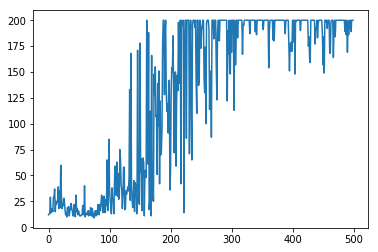

In [9]:
plt.plot(range(episode_count),all_rewards)
plt.show()

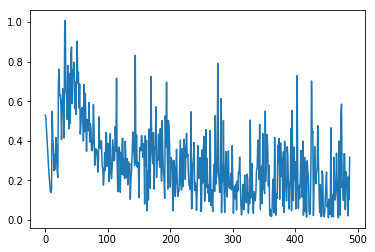

In [10]:
plt.plot(range(len(all_losses)),all_losses)
plt.show()